# トイレ掃除双腕ロボット制御実験群

## ROS 2 for xArm 利用上の注意

### ノードの立ち上げ

xArmのROSコマンドは、それぞれ別ターミナルで予め実行しておくこと
```
term1# ros2 launch xarm_api xarm7_driver.launch.py robot_ip:=192.168.0.95 hw_ns:=left
term2# ros2 launch xarm_api xarm7_driver.launch.py robot_ip:=192.168.0.97 hw_ns:=right
```

### （初回立ち上げ時） 必要なサービスの有効化

position_aaなど、デフォルトでは使用していないserviceを使っている

そのため、install側にxarm_user_config.yamlを新規作成、必要なサービスを有効しておくこと

In [1]:
import rclpy
from rclpy.node import Node
from sensor_msgs.msg import Image
from std_msgs.msg import String
from cv_bridge import CvBridge, CvBridgeError
import cv2
import numpy as np
import time
from xarm_msgs.srv import SetInt16ById,SetInt16, MoveCartesian, MoveJoint, MoveVelocity
from xarm_msgs.msg import RobotMsg

from scipy import interpolate # 欠損データの補完


import json

In [2]:
### xArm Setup Client
# This class is used to setup the xArm robot. It enables all joints and sets the proper mode and state.
# The mode is set to 0 (position mode) and the state is set to 0 (ready).
# The class also provides methods to change the mode to handteach and velocity mode.
# The handteach mode is mode 2 and the velocity mode is mode 5.

class XArmSetupClient(Node):
    def __init__(self,hw_ns):
        super().__init__('xarm_setup_client')

        self.hw_ns = hw_ns
        # Enable all joints
        self.motion_enable_client = self.create_client(SetInt16ById, f'/{self.hw_ns}/motion_enable')
        self.motion_enable_request = SetInt16ById.Request()
        self.motion_enable_request.id = 8
        self.motion_enable_request.data = 1

        # Set proper mode and state
        self.set_mode_client = self.create_client(SetInt16, f'/{self.hw_ns}/set_mode')
        self.set_mode_request = SetInt16.Request()
        self.set_mode_request.data = 0

        self.set_state_client = self.create_client(SetInt16, f'/{self.hw_ns}/set_state')
        self.set_state_request = SetInt16.Request()
        self.set_state_request.data = 0
        self.call_services(mode = 0)

    def call_services(self, mode = 0):
        time.sleep(0.2) # TODO:左右同時におくるとパケロスが生じるような挙動をするためのバッドノウハウ
        # Enable all joints
        if not self.motion_enable_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/motion_enable is not available!')
            return
        self.motion_enable_client.call_async(self.motion_enable_request)

        # Set mode and state
        self.set_mode_request.data = mode
        
        if not self.set_mode_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_mode is not available!')
            return
        self.set_mode_client.call_async(self.set_mode_request)

        if not self.set_state_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_state is not available!')
            return
        self.set_state_client.call_async(self.set_state_request)

    def call_mode_handteach(self):
        self.call_services(mode = 2)

    def call_mode_position(self):
        self.call_services(mode = 0)
        
    def call_mode_vel(self):
        self.call_services(mode = 5)



In [3]:
import paramiko
import time


In [4]:
import ipywidgets as widgets

In [5]:
## xArm State Subscriber
# This class is used to subscribe to the xArm state topic. It stores the current state of the xArm robot.
# The state is stored in the xarm_state variable.
class xArmStateSubscriber(Node):
        def __init__(self,hw_ns):
            super().__init__('xarm_state_subscriber')

            self.hw_ns = hw_ns
            self.subscription = self.create_subscription(
                RobotMsg,
                f'/{self.hw_ns}/robot_states',
                self.listener_callback,
                10)
            self.subscription  # prevent unused variable warning
            self.xarm_state = RobotMsg()
    
        def listener_callback(self, msg):
            self.xarm_state = msg
            #self.get_logger().info(f'xarm state: {msg}')

## xArm Service Client
# This class is used to send requests to the xArm robot. It provides methods to move the robot in cartesian and joint space.
# The methods send_move_cartesian_request and send_joint_move_request are used to move the robot in cartesian and joint space respectively.
# The methods send_move_cartesian_relative_request and send_joint_move_relative_request are used to move the robot in cartesian and joint space relatively.
# The method send_vel_request is used to set the velocity of the robot.
class XArmServiceClient(Node):

    def __init__(self,hw_ns):
        super().__init__('xarm_service_client')
        self.hw_ns = hw_ns
        # Cartesian linear motion
        self.set_position_client = self.create_client(MoveCartesian, f'/{self.hw_ns}/set_position')
        self.set_tool_position_client = self.create_client(MoveCartesian, f'/{self.hw_ns}/set_tool_position')
        self.set_position_aa_client = self.create_client(MoveCartesian, f'/{self.hw_ns}/set_position_aa')

        # 軸を指定するサービス。座標系だけで与えると、意図しない姿勢で実行される事がある
        self.set_joint_client = self.create_client(MoveJoint, f'/{self.hw_ns}/set_servo_angle')

         # xArmの速度に変換するためのサービス
        self.set_position_client = self.create_client(MoveVelocity, f'/{self.hw_ns}/vc_set_cartesian_velocity')   
    

    def send_move_cartesian_request(self, pose, speed, acc, mvtime):
        # ここでリクエストデータに基づいて処理を行う
        # Set position
        if not self.set_position_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_position is not available!')
            return

        request = MoveCartesian.Request()
        request.pose = pose
        request.speed = speed
        request.acc = acc
        request.mvtime = mvtime
        request.wait = True

        # 非同期でサービスをコール
        self.future = self.set_position_client.call_async(request)

    def send_move_cartesian_aa_request(self, pose, speed, acc, mvtime, is_tool_coord=True, is_wait=True):
        # ここでリクエストデータに基づいて処理を行う
        # Set position
        if not self.set_position_aa_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_position_aa is not available!')
            return

        request = MoveCartesian.Request()
        request.pose = pose
        request.speed = speed
        request.acc = acc
        request.mvtime = mvtime
        request.wait = is_wait
        request.is_tool_coord = is_tool_coord
        
        # 非同期でサービスをコール
        self.future = self.set_position_aa_client.call_async(request)

    def send_move_cartesian_aa_relative_request(self, pose, speed, acc, mvtime, is_tool_coord=True):
        # ここでリクエストデータに基づいて処理を行う
        # Set position
        if not self.set_position_aa_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_position_aa is not available!')
            return

        request = MoveCartesian.Request()
        request.pose = pose
        request.speed = speed
        request.acc = acc
        request.mvtime = mvtime
        request.wait = True
        request.relative = True
        request.is_tool_coord = is_tool_coord
        
        # 非同期でサービスをコール
        self.future = self.set_position_aa_client.call_async(request)

    
    def send_move_tool_positon_request(self, pose, speed, acc, mvtime, is_tool_coord=True):
        # ここでリクエストデータに基づいて処理を行う
        # Set position
        if not self.set_tool_position_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_tool_position is not available!')
            return

        request = MoveCartesian.Request()
        request.pose = pose
        request.speed = speed
        request.acc = acc
        request.mvtime = mvtime
        request.wait = True
        request.is_tool_coord = is_tool_coord
        
        # 非同期でサービスをコール
        self.future = self.set_tool_position_client.call_async(request)

    
    def send_move_cartesian_relative_request(self, pose, speed, acc, mvtime):
        # ここでリクエストデータに基づいて処理を行う
        # Set position
        if not self.set_position_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_position is not available!')
            return

        request = MoveCartesian.Request()
        request.pose = pose
        request.speed = speed
        request.acc = acc
        request.mvtime = mvtime
        request.relative = True
        request.wait = True

        # 非同期でサービスをコール
        self.future = self.set_position_client.call_async(request)

    def send_joint_move_request(self, joint, speed, acc, mvtime):
        # ここでリクエストデータに基づいて処理を行う
        # Set position
        if not self.set_joint_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_servo_angle is not available!')
            return
        
        request = MoveJoint.Request()
        request.angles = joint
        request.speed = speed
        request.acc = acc
        request.mvtime = mvtime
        request.wait = True

        # 非同期でサービスをコール
        self.future = self.set_joint_client.call_async(request)

    def send_joint_move_relative_request(self, joint, speed, acc, mvtime):
        # ここでリクエストデータに基づいて処理を行う
        # Set position
        if not self.set_joint_client.wait_for_service(timeout_sec=3.0):
            self.get_logger().error('Service /xarm/set_servo_angle is not available!')
            return
        
        request = MoveJoint.Request()
        request.angles = joint
        request.speed = speed
        request.acc = acc
        request.mvtime = mvtime
        request.relative = True
        request.wait = True

        # 非同期でサービスをコール
        self.future = self.set_joint_client.call_async(request)

    def send_vel_request(self,vel_linear_x, vel_linear_y, vel_linear_z, vel_linear_roll, vel_linear_pitch, vel_angular_yaw):
        ### 動作。
        ## TODO: 時間上限を決める事。でないとエラーまで無限にうごく
        request = MoveVelocity.Request()
        request.speeds = [vel_linear_x, vel_linear_y, vel_linear_z, vel_linear_roll, vel_linear_pitch, vel_angular_yaw]

        # 非同期でサービスをコール
        self.future = self.set_position_client.call_async(request)


In [6]:
rclpy.init() # Initialize the rclpy library

In [7]:
"""
# SSHクライアントのインスタンスを作成
client = paramiko.SSHClient()

# 初めてのSSH接続時にサーバーの公開鍵を自動的に受け入れるように設定
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

# SSHサーバーに接続
remote   = '192.168.1.250'
username = 'ubuntu'
password = 'ubuntu'
client.connect(remote, username=username, password=password)
"""

"\n# SSHクライアントのインスタンスを作成\nclient = paramiko.SSHClient()\n\n# 初めてのSSH接続時にサーバーの公開鍵を自動的に受け入れるように設定\nclient.set_missing_host_key_policy(paramiko.AutoAddPolicy())\n\n# SSHサーバーに接続\nremote   = '192.168.1.250'\nusername = 'ubuntu'\npassword = 'ubuntu'\nclient.connect(remote, username=username, password=password)\n"

In [8]:
"""
# 移動の方
value_dist = 0.0

float_range = widgets.FloatSlider(
    value=0.1,
    min=-1.0,
    max=1.0,
    step=0.01,
    description='Scart X value:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

float_range.layout.width = '80%'

value_dist = float_range.value

def update_value(change):
    global value_dist
    value_dist = change.new

# スライダーの値の変更を監視
float_range.observe(update_value, names='value')


#############
## 角度の方
value_angle = 0.0

float_angle = widgets.FloatSlider(
    value=0.0,
    min=-1.0,
    max=1.0,
    step=0.1,
    description='Scart Z angle:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

float_angle.layout.width = '80%'

value_angle = float_angle.value

def update_angle(change):
    global value_angle
    value_angle = change.new

# スライダーの値の変更を監視
float_angle.observe(update_angle, names='value')


# ウィジェット類の表示
#display(float_range)
#display(float_angle)

widgets.VBox([float_range, float_angle])
"""

"\n# 移動の方\nvalue_dist = 0.0\n\nfloat_range = widgets.FloatSlider(\n    value=0.1,\n    min=-1.0,\n    max=1.0,\n    step=0.01,\n    description='Scart X value:',\n    disabled=False,\n    continuous_update=False,\n    orientation='horizontal',\n    readout=True,\n    readout_format='.2f',\n)\n\nfloat_range.layout.width = '80%'\n\nvalue_dist = float_range.value\n\ndef update_value(change):\n    global value_dist\n    value_dist = change.new\n\n# スライダーの値の変更を監視\nfloat_range.observe(update_value, names='value')\n\n\n#############\n## 角度の方\nvalue_angle = 0.0\n\nfloat_angle = widgets.FloatSlider(\n    value=0.0,\n    min=-1.0,\n    max=1.0,\n    step=0.1,\n    description='Scart Z angle:',\n    disabled=False,\n    continuous_update=False,\n    orientation='horizontal',\n    readout=True,\n    readout_format='.1f',\n)\n\nfloat_angle.layout.width = '80%'\n\nvalue_angle = float_angle.value\n\ndef update_angle(change):\n    global value_angle\n    value_angle = change.new\n\n# スライダーの値の変更を監視\nfl

In [9]:
"""
#### Scart実験

def execute_remote_command(change):
    i = value_dist
    j = value_angle

    print(f"i: {i}, j: {j}")

    # リモートでコマンドを実行
    cmd = 'rostopic pub -1 /cmd_vel geometry_msgs/Twist "{linear: {x: ' + str(i) + ', y: 0.0, z: 0.0}, angular: {x: 0.0, y: 0.0, z: ' + str(j) + '}}"'
    stdin, stdout, stderr = client.exec_command(cmd)

    # コマンドの実行結果を出力
    print(stdout.read().decode())

# Buttonウィジェットを作成
execute_button = widgets.Button(description="Execute")
execute_button.on_click(execute_remote_command)

# ウィジェットを表示
widgets.VBox([execute_button])
"""

'\n#### Scart実験\n\ndef execute_remote_command(change):\n    i = value_dist\n    j = value_angle\n\n    print(f"i: {i}, j: {j}")\n\n    # リモートでコマンドを実行\n    cmd = \'rostopic pub -1 /cmd_vel geometry_msgs/Twist "{linear: {x: \' + str(i) + \', y: 0.0, z: 0.0}, angular: {x: 0.0, y: 0.0, z: \' + str(j) + \'}}"\'\n    stdin, stdout, stderr = client.exec_command(cmd)\n\n    # コマンドの実行結果を出力\n    print(stdout.read().decode())\n\n# Buttonウィジェットを作成\nexecute_button = widgets.Button(description="Execute")\nexecute_button.on_click(execute_remote_command)\n\n# ウィジェットを表示\nwidgets.VBox([execute_button])\n'

In [10]:
"""
#### Scart実験
## Way there AND Way Out

## 行き
def execute_way_there_command(change):
    pathdata = [
        [0.5,0.0],
        [0.4,0.0],
        [0.3,0.0],
        [0.0,1.0],
        [0.0,0.7],
        [0.15,0.0],
        [0.1,0.0]
    ]
    
    for pd in pathdata:
        i = pd[0]
        j = pd[1]
        print(f"X:{pd[0]}, YAW:{pd[1]}")
    
        # リモートでコマンドを実行
        cmd = 'rostopic pub -1 /cmd_vel geometry_msgs/Twist "{linear: {x: ' + str(i) + ', y: 0.0, z: 0.0}, angular: {x: 0.0, y: 0.0, z: ' + str(j) + '}}"'
        stdin, stdout, stderr = client.exec_command(cmd)
        time.sleep(3)

## 戻り
def execute_way_out_command(change):
    pathdata = [
        [-0.15,0.0],   
        [-0.1,0.0],   
        [0.0,1.0],
        [0.0,0.7],
        [0.5,0.0],
        [0.4,0.0],
        [0.2,0.0],
        [0.0,-1.0],
        [0.0,-1.0],
        [0.0,-1.0],
        [0.0,-0.4]
    ]
    for pd in pathdata:
        i = pd[0]
        j = pd[1]
        print(f"X:{pd[0]}, YAW:{pd[1]}")
    
        # リモートでコマンドを実行
        cmd = 'rostopic pub -1 /cmd_vel geometry_msgs/Twist "{linear: {x: ' + str(i) + ', y: 0.0, z: 0.0}, angular: {x: 0.0, y: 0.0, z: ' + str(j) + '}}"'
        stdin, stdout, stderr = client.exec_command(cmd)
        time.sleep(3)
    


# Buttonウィジェットを作成
execute_way_there_button = widgets.Button(description="行き")
execute_way_there_button.on_click(execute_way_there_command)

execute_way_out_button = widgets.Button(description="帰り")
execute_way_out_button.on_click(execute_way_out_command)

# ウィジェットを表示
#widgets.VBox([execute_way_there_button, execute_way_out_button])
widgets.VBox([execute_way_there_button])


"""

'\n#### Scart実験\n## Way there AND Way Out\n\n## 行き\ndef execute_way_there_command(change):\n    pathdata = [\n        [0.5,0.0],\n        [0.4,0.0],\n        [0.3,0.0],\n        [0.0,1.0],\n        [0.0,0.7],\n        [0.15,0.0],\n        [0.1,0.0]\n    ]\n    \n    for pd in pathdata:\n        i = pd[0]\n        j = pd[1]\n        print(f"X:{pd[0]}, YAW:{pd[1]}")\n    \n        # リモートでコマンドを実行\n        cmd = \'rostopic pub -1 /cmd_vel geometry_msgs/Twist "{linear: {x: \' + str(i) + \', y: 0.0, z: 0.0}, angular: {x: 0.0, y: 0.0, z: \' + str(j) + \'}}"\'\n        stdin, stdout, stderr = client.exec_command(cmd)\n        time.sleep(3)\n\n## 戻り\ndef execute_way_out_command(change):\n    pathdata = [\n        [-0.15,0.0],   \n        [-0.1,0.0],   \n        [0.0,1.0],\n        [0.0,0.7],\n        [0.5,0.0],\n        [0.4,0.0],\n        [0.2,0.0],\n        [0.0,-1.0],\n        [0.0,-1.0],\n        [0.0,-1.0],\n        [0.0,-0.4]\n    ]\n    for pd in pathdata:\n        i = pd[0]\n        j =

In [11]:
# Create the xArm setup clients. These clients are used to setup the xArm robot.
xarm_right_setup_client = XArmSetupClient(hw_ns='right')
xarm_left_setup_client = XArmSetupClient(hw_ns='left')


[WARN] [1714463980.102576551] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


In [12]:
## Create the xArm service clients. These clients are used to send requests to the xArm robot.
# For Right Arm
xarm_right_service_client = XArmServiceClient(hw_ns='right')
xarm_right_state_subscriber = xArmStateSubscriber(hw_ns='right')
# For Left Arm
xarm_left_service_client = XArmServiceClient(hw_ns='left')
xarm_left_state_subscriber = xArmStateSubscriber(hw_ns='left')

[WARN] [1714463985.142083834] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.
[WARN] [1714463985.205361359] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


In [13]:
# Call state subscriber to get the current state of the xArm robot Right Arm
rclpy.spin_once(xarm_right_state_subscriber)
print(xarm_right_state_subscriber.xarm_state)

xarm_msgs.msg.RobotMsg(header=std_msgs.msg.Header(stamp=builtin_interfaces.msg.Time(sec=1714463988, nanosec=833290381), frame_id=''), state=2, mode=0, cmdnum=0, mt_brake=127, mt_able=127, err=0, warn=0, angle=[-1.1573079824447632, -1.3649111986160278, 0.644486665725708, 1.0249561071395874, -1.9201796054840088, 1.4778735637664795, 1.356598973274231], pose=array([ 6.2688214e+02,  1.4584154e+02,  3.9126761e+02,  2.1552411e-01,
       -1.3691299e-02,  9.3314767e-01], dtype=float32), offset=array([0., 0., 0., 0., 0., 0.], dtype=float32))


In [14]:
xarm_right_state_subscriber.xarm_state.angle # Joint angles of the xArm robot

array('f', [-1.1573079824447632, -1.3649111986160278, 0.644486665725708, 1.0249561071395874, -1.9201796054840088, 1.4778735637664795, 1.356598973274231])

In [15]:
xarm_right_state_subscriber.xarm_state.pose # Pose of the xArm robot

array([ 6.2688214e+02,  1.4584154e+02,  3.9126761e+02,  2.1552411e-01,
       -1.3691299e-02,  9.3314767e-01], dtype=float32)

In [16]:
# Call state subscriber to get the current state of the xArm robot Left Arm
rclpy.spin_once(xarm_left_state_subscriber)
print(xarm_left_state_subscriber.xarm_state)
xarm_left_state_subscriber.xarm_state.pose
xarm_left_state_subscriber.xarm_state.angle

xarm_left_state_subscriber.xarm_state.state

xarm_msgs.msg.RobotMsg(header=std_msgs.msg.Header(stamp=builtin_interfaces.msg.Time(sec=1714463999, nanosec=839140458), frame_id=''), state=2, mode=0, cmdnum=0, mt_brake=127, mt_able=127, err=0, warn=0, angle=[0.6121273636817932, 1.436981439590454, -0.6347631812095642, -0.9242196083068848, 2.396275520324707, -1.7643368244171143, -0.032200172543525696], pose=array([ 5.1584393e+02, -2.4618040e+02,  4.8170923e+02,  5.2271828e-02,
       -3.7407328e-03, -3.1381760e-02], dtype=float32), offset=array([0., 0., 0., 0., 0., 0.], dtype=float32))


2

In [17]:
## Move the xArm robot to a safe position
# 腕を引き込んだ状態
def safe_pose_right():
    #pose = [-1.392519474029541, -0.7546999454498291, 0.3516403138637543, 1.0841939449310303, -2.1966123580932617, 1.7574831247329712, 1.0771334171295166]
    pose = [-0.14608226716518402, -0.6015805602073669, 0.14084084331989288, 0.5417478084564209, -2.801072359085083, 2.775310516357422, 0.2948301136493683]
    xarm_right_service_client.send_joint_move_request(pose, 0.10, 15.0, 0.0)

def safe_pose_left():
    #pose = [0.1090813875198364, 1.1033000946044922, 5.653444290161133, -1.3261239528656006, 2.2007319927215576, -1.6787222623825073, -0.2651842534542084]
    #pose =   [-1.04399952292442322, 0.599802553653717, -0.10290651768445969, -0.5282748937606812, 3.0647754669189453, -2.7917191982269287, -0.005691657308489084]
    pose =   [-0.10741592198610306, 0.576759934425354, 0.25412997603416443, -0.5265129804611206, 3.1845130920410156, -2.831953287124634, -0.14359083771705627]
    xarm_left_service_client.send_joint_move_request(pose, 0.10, 15.0, 0.0 )

# 腕を広げた状態
def safe_pose_2_right(movespeed=0.10):
    #pose = [1.1090813875198364, 1.1033000946044922, 5.653444290161133, -1.3261239528656006, 2.2007319927215576, -1.6787222623825073, -0.2651842534542084]
    pose =  [-1.184085488319397, -1.33247709274292, 0.4902084767818451, 0.6737435460090637, -2.085700035095215, 1.7999615669250488, 0.29482343792915344]
    xarm_right_service_client.send_joint_move_request(pose, movespeed, 15.0, 0.0)

def safe_pose_2_left(movespeed=0.10):
    #pose = [1.1090813875198364, 1.1033000946044922, 5.653444290161133, -1.3261239528656006, 2.2007319927215576, -1.6787222623825073, -0.2651842534542084]
    pose = [1.0965795516967773, 1.021103858947754, -0.3851442337036133, -0.7619876861572266, 2.307615280151367, -1.9097139835357666, -0.1054535061120987]
    xarm_left_service_client.send_joint_move_request(pose, movespeed, 15.0, 0.0)   

# カメラ撮影姿勢
def safe_pose_camera_right():
    pose =  [-0.12395907193422318, -1.7742117643356323, 0.1307622790336609, 1.0916132926940918, -3.191661834716797, 1.0588072538375854, 0.29480618238449097]
    xarm_right_service_client.send_joint_move_request(pose, 0.10, 15.0, 0.0)

def safe_pose_camera_left():
    pose =  [0.21721550822257996, 1.8423646688461304, 0.06038323789834976, -0.867560088634491, 3.1182608604431152, -1.4170492887496948, -0.1435825228691101]
    xarm_left_service_client.send_joint_move_request(pose, 0.10, 15.0, 0.0)   

In [18]:
def set_safe_pose_1():
    # 腕を引き込んだ状態にする
    xarm_right_setup_client.call_services(mode=0)
    xarm_left_setup_client.call_services(mode=0)
    safe_pose_right()
    safe_pose_left()

# Buttonウィジェットを作成
set_safe_pose_1_button = widgets.Button(description="Safe Pose 1")
set_safe_pose_1_button.on_click(set_safe_pose_1_button)


# ウィジェットを表示
widgets.VBox([set_safe_pose_1_button])


In [19]:
# 手動教示モード。エラーからの復帰にもつかえる

def set_hand_teach_mode(change):
    xarm_right_setup_client.call_mode_handteach()
    xarm_left_setup_client.call_mode_handteach()

# Buttonウィジェットを作成
set_hand_teach_mode_button = widgets.Button(description="ハンチドティーチ")
set_hand_teach_mode_button.on_click(set_hand_teach_mode)


# ウィジェットを表示
widgets.VBox([set_hand_teach_mode_button])


In [31]:
class JSONSubscriber(Node):
    def __init__(self):
        super().__init__('json_subscriber')
        self.subscription = self.create_subscription(
            String,
            'json_data',
            self.json_callback,
            10
        )
        self.subscription  # prevent unused variable warning
        
        # Initialize recent offsets and yaw
        self.recent_x_offset = 0.0
        self.recent_y_offset = 0.0
        self.recent_yaw_degrees = 0

    def json_callback(self, msg):
        try:
            # Parse the JSON message
            data = json.loads(msg.data)

            # Extract values of interest
            A_x_values = data['point_A']['x']
            A_y_values = data['point_A']['y']
            B_x_values = data['point_B']['x']
            B_y_values = data['point_B']['y']
            angle = data['yaw']

            # Update recent offsets and yaw
            self.recent_x_offset = sum(A_x_values + B_x_values) / (len(A_x_values) + len(B_x_values))*0.5
            self.recent_y_offset = sum(A_y_values + B_y_values) / (len(A_y_values) + len(B_y_values))*0.5
            self.recent_yaw_degrees = angle*1.0

            # Do something with the extracted values
            #self.get_logger().info('Received JSON data:')
            #self.get_logger().info('A_x_values: %s' % A_x_values)
            #self.get_logger().info('A_y_values: %s' % A_y_values)
            #self.get_logger().info('B_x_values: %s' % B_x_values)
            #self.get_logger().info('B_y_values: %s' % B_y_values)
            #self.get_logger().info('angle: %s' % angle)
        except Exception as e:
            self.get_logger().error('Error processing JSON data: %s' % str(e))

        return self.recent_x_offset, self.recent_y_offset , self.recent_yaw_degrees

In [32]:
## トイレ便器を模擬した楕円軌道の実験
# 姿勢データ
from scipy.interpolate import interp1d


def calculate_trajectory(start_long, start_short, radius_long, radius_short, x_offset, y_offset, yaw_degrees):
    # 度をラジアンに変換
    yaw_radians = np.radians(yaw_degrees)

    # 回転行列を定義
    rotation_matrix = np.array([
        [np.cos(yaw_radians), -np.sin(yaw_radians)],
        [np.sin(yaw_radians), np.cos(yaw_radians)]
    ])

    # 基本点群を定義
    points = np.array([
        [start_long + (radius_long * i) + x_offset, start_short + (radius_short * j) + y_offset]
        for i, j in zip([0.01, 0.10, 0.20, 0.40, 0.60, 0.80, 0.90, 1.00,  0.90,  0.80,  0.60,  0.40,  0.20,  0.10, 0.01],
                        [0.0, 0.40, 0.75, 0.90, 1.00, 0.90, 0.50, 0.00, -0.50, -0.90, -1.00, -0.90, -0.75, -0.40, 0.0])
    ])

    # pointsを回転させる
    rotated_points = np.dot(points - [start_long + x_offset, start_short + y_offset], rotation_matrix.T) + [start_long + x_offset, start_short + y_offset]

    # 補間による滑らかな軌跡生成
    t = np.linspace(0, 1, len(rotated_points))
    t_fine = np.linspace(0, 1, 2 * len(rotated_points))
    interp_func_x = interp1d(t, rotated_points[:, 0], kind='cubic')
    interp_func_y = interp1d(t, rotated_points[:, 1], kind='cubic')
    x_fine = interp_func_x(t_fine)
    y_fine = interp_func_y(t_fine)
    trajectory = np.vstack((x_fine, y_fine)).T
    
    return trajectory, rotated_points

# OuterとInnerの軌道を計算
recent_start_long = 390
recent_start_short = -187
recent_radius_long = 220
recent_radius_short=100

##### TODO:From camera Info ##### 
recent_x_offset = 0
recent_y_offset = 0
recent_yaw_degrees = 0

#jsub = JSONSubscriber()
#recent_x_offset ,recent_y_offset ,recent_yaw_degrees = jsub.json_callback()

# Create an instance of JSONSubscriber
jsub = JSONSubscriber()

rclpy.spin_once(jsub, timeout_sec=0.2)

# Access recent_x_offset, recent_y_offset, and recent_yaw_degrees attributes
recent_x_offset = jsub.recent_x_offset
recent_y_offset = jsub.recent_y_offset
recent_yaw_degrees = jsub.recent_yaw_degrees

recent_x_offset = int(recent_x_offset)
recent_y_offset = int(recent_y_offset)
recent_yaw_degrees = int(recent_yaw_degrees)


trajectory_outer, rotated_points_outer = calculate_trajectory(
    start_long=recent_start_long, start_short=recent_start_short, radius_long=recent_radius_long, radius_short=recent_radius_short, 
    x_offset=recent_x_offset, y_offset=recent_y_offset, yaw_degrees=recent_yaw_degrees)

trajectory_inner, rotated_points_inner = calculate_trajectory(
    start_long= (recent_start_long) + (200 * 0.6 * 0.5), start_short=recent_start_short, radius_long=recent_radius_long * 0.6, radius_short=recent_radius_short * 0.6, 
    x_offset=recent_x_offset, y_offset=recent_y_offset, yaw_degrees=recent_yaw_degrees)


#################### 速度ベクトルによる軌跡確定 ######################
# numpyを使って曲線を補間し、number点で分割する
# 分割数が少ないと、速度がリミットを超える
# TODO:安全モードを緩くすると速度は確保できるが、当分の間は低速で実施すること
number = len(rotated_points_outer) * 6


############ Outer ################

t = np.linspace(0, 1, len(rotated_points_outer))
t_fine = np.linspace(0, 1, number)

# X座標とY座標でそれぞれ補間関数を生成
interp_func_x = interpolate.interp1d(t, rotated_points_outer[:, 0], kind='cubic')
interp_func_y = interpolate.interp1d(t, rotated_points_outer[:, 1], kind='cubic')

# 生成した補間関数を使って、number点のX座標とY座標を計算
x_fine = interp_func_x(t_fine)
y_fine = interp_func_y(t_fine)

# 結果を結合して軌跡データを生成
trajectory = np.vstack((x_fine, y_fine)).T
#print(trajectory)


# 速度の計算
vel_commands = []
for i in range(1, len(trajectory_outer)):
    # 現在の点と前の点の差分を計算
    dx = trajectory_outer[i][0] - trajectory_outer[i-1][0]
    dy = trajectory_outer[i][1] - trajectory_outer[i-1][1]
    vel_commands.append([dx, dy])


################ inner #####################
number = int(number * 0.6 * 0.5)  ##内側は小さい
t = np.linspace(0, 1, len(rotated_points_inner))
t_fine = np.linspace(0, 1, number)

# X座標とY座標でそれぞれ補間関数を生成
interp_func_x = interpolate.interp1d(t, rotated_points_inner[:, 0], kind='cubic')
interp_func_y = interpolate.interp1d(t, rotated_points_inner[:, 1], kind='cubic')

# 生成した補間関数を使って、number点のX座標とY座標を計算
x_fine = interp_func_x(t_fine)
y_fine = interp_func_y(t_fine)

# 結果を結合して軌跡データを生成
trajectory_inner = np.vstack((x_fine, y_fine)).T
#print(trajectory)


# 速度の計算
vel_commands_inner = []
for i in range(1, len(trajectory_inner)):
    # 現在の点と前の点の差分を計算
    dx_inner = trajectory_inner[i][0] - trajectory_inner[i-1][0]
    dy_inner = trajectory_inner[i][1] - trajectory_inner[i-1][1]
    vel_commands_inner.append([dx_inner, dy_inner])



[ERROR] [1714464530.397343364] [json_subscriber]: Error processing JSON data: can't multiply sequence by non-int of type 'float'


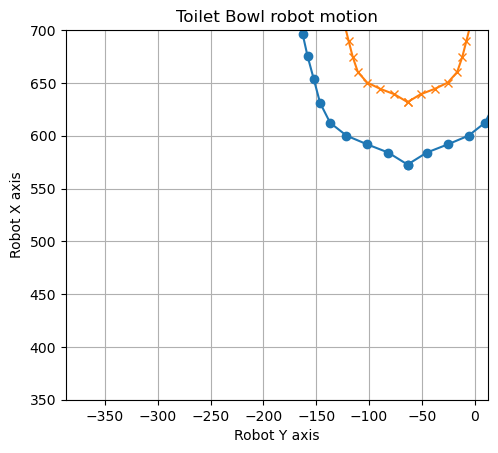

In [27]:
## 確認用に動作点をプロットする
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# データをプロット
plt.plot(trajectory_outer[:,1], trajectory_outer[:,0], marker='o', linestyle='-')  # 点を'○'で、線で結ぶ
plt.plot(trajectory_inner[:,1], trajectory_inner[:,0], marker='x', linestyle='-')  # 点を'x'で、線で結ぶ


# RobotのY軸の最大値最小値を設定
plt.xlim(-187 - 200, -187 + 200)

# RobotのX軸の最大値最小値を設定
plt.ylim(700 - 350, 700)

# アスペクト比を等しく設定
plt.gca().set_aspect('equal', adjustable='box')


# タイトルと軸ラベルを追加
plt.title('Toilet Bowl robot motion')
plt.xlabel('Robot Y axis')
plt.ylabel('Robot X axis')

# グリッドを表示
plt.grid(True)



In [ ]:
def waitForMovingLeft():
    recent_state_left = 99 #番兵法的
    while recent_state_left != 2:
        print(f"left state::{recent_state_left}")
        time.sleep(1)
        rclpy.spin_once(xarm_left_state_subscriber)
        recent_state_left = xarm_left_state_subscriber.xarm_state.state

def waitForMovingRight():
    recent_state_right = 99 #番兵法的
    while recent_state_right != 2:
        print(f"right state:{recent_state_right}")
        time.sleep(1)
        rclpy.spin_once(xarm_right_state_subscriber)
        recent_state_right = xarm_right_state_subscriber.xarm_state.state

def waitForMovingBoth():
    ### TODO: mode==5でつかうと、延々と止まらないので何らかのバリデーションを入れておく
    recent_state_left = 99 #番兵法的
    recent_state_right = 99 #番兵法的
    while recent_state_left != 2 and recent_state_right != 2:
        print(f"left state::{recent_state_left}")
        print(f"right state::{recent_state_right}")
        time.sleep(1)
        rclpy.spin_once(xarm_left_state_subscriber)
        recent_state_left = xarm_left_state_subscriber.xarm_state.state
        rclpy.spin_once(xarm_right_state_subscriber)
        recent_state_right = xarm_right_state_subscriber.xarm_state.state

In [ ]:
def waitForModeChangeLeft(target_mode):
    recent_mode_left = 99 #番兵法的
    while recent_mode_left != target_mode:
        print(f"left mode::{recent_mode_left}")
        time.sleep(0.1)
        rclpy.spin_once(xarm_left_state_subscriber)
        recent_mode_left = xarm_left_state_subscriber.xarm_state.mode

def waitForModeChangeRight(target_mode):
    recent_mode_right = 99 #番兵法的
    while recent_mode_right != target_mode:
        print(f"right mode:{recent_mode_right}")
        time.sleep(0.1)
        rclpy.spin_once(xarm_right_state_subscriber)
        recent_mode_right = xarm_right_state_subscriber.xarm_state.mode

def waitForModeChangeBoth(target_mode):
    ### TODO: mode==5でつかうと、延々と止まらないので何らかのバリデーションを入れておく
    recent_mode_left = 99 #番兵法的
    recent_mode_right = 99 #番兵法的
    while recent_mode_left != target_mode and recent_mode_right != target_mode:
        print(f"left mode::{recent_mode_left}")
        print(f"right mode:{recent_mode_right}")
        time.sleep(0.1)
        rclpy.spin_once(xarm_left_state_subscriber)
        recent_mode_left = xarm_left_state_subscriber.xarm_state.mode
        rclpy.spin_once(xarm_right_state_subscriber)
        recent_mode_right = xarm_right_state_subscriber.xarm_state.mode

In [ ]:
def set_safe_pose_2():
    # 腕を広げた状態にする
    xarm_right_setup_client.call_services(mode=0)
    xarm_left_setup_client.call_services(mode=0)
    
    waitForModeChangeBoth(target_mode=0)
    
    safe_pose_2_right()
    safe_pose_2_left()

# Buttonウィジェットを作成
set_safe_pose_2_button = widgets.Button(description="Safe Pose 2")
set_safe_pose_2_button.on_click(set_safe_pose_2_button)

# ウィジェットを表示
widgets.VBox([set_safe_pose_2_button])

In [ ]:
def washSafePlace():
    # 実験用安全姿勢
    xarm_right_setup_client.call_services(mode=0)
    xarm_left_setup_client.call_services(mode=0)
    
    ## 初期姿勢
    # 直前の安全姿勢はsafe_pose_2の方が動作が安定する
    xarm_right_service_client.send_move_cartesian_aa_request([ 550.0, -187.0, 500.0, 0.0, 0.0, 0.0],  100.0, 50.0, 0.0)
    time.sleep(0.1)
    xarm_left_service_client.send_move_cartesian_aa_request([  530.0, -120.0, 500.0, 0.0, 0.0, 0.0] , 100.0, 50.0, 0.0)

In [ ]:

#####################################
# トイレ掃除用メソッド
#####################################

def rightHandJogMove():
    ##TODO: バッドノウハウ的。何か動かさないと、最初の動作が以上座標として処理されるケースがあるため
    xarm_right_service_client.send_vel_request( -10.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    time.sleep(1)
    xarm_right_service_client.send_vel_request( 10.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    time.sleep(1)
    xarm_right_service_client.send_vel_request(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    time.sleep(1)

def rihgtHandToOriginPlace(pose):
    xarm_right_service_client.send_joint_move_request(pose, 0.20, 30.0, 0.0)

def moveFistTrajPointRight(trajXY):
    xarm_right_setup_client.call_services(mode=0)
    time.sleep(0.2)
    hand_pitch = 5.25748730e-01 ##リーチ長さを稼ぐいみで３０度ねかす
    xarm_right_service_client.send_move_cartesian_aa_request([ trajXY[0], trajXY[1], 600.0, 0.0, hand_pitch, 0.0],  100.0, 50.0, 0.0)

def moveBowlCenterRight(movespeed=0.20):
    ## 安全姿勢に戻る前の経由点として
    pose = [-1.3013648986816406, -0.7284491658210754, 0.277678519487381, 1.2147583961486816, -2.2611629962921143, 1.6684703826904297, 0.9717563390731812]
    xarm_right_service_client.send_joint_move_request(pose, movespeed, 30.0, 0.0)

In [ ]:
def toiletCoverOpen():
    coverOpenPlace = [  580.0, -160.0, 750.0, 0.0, 0.0, 0.0]
    xarm_left_service_client.send_move_cartesian_aa_request(coverOpenPlace , 300.0, 500.0, 0.0)

    time.sleep(1)
    coverOpenPlace[1] += 90 #y
    xarm_left_service_client.send_move_cartesian_aa_request(coverOpenPlace , 100.0, 300.0, 0.0)
    
    time.sleep(1)
    coverOpenPlace[2] -= 100 #z
    xarm_left_service_client.send_move_cartesian_aa_request(coverOpenPlace , 100.0, 300.0, 0.0)
    
    time.sleep(1)
    coverOpenPlace[0] += 140 #x
    xarm_left_service_client.send_move_cartesian_aa_request(coverOpenPlace , 100.0, 300.0, 0.0)


In [ ]:
#######################################
### TODO:: 初期姿勢を誤るとフレームを割る
xarm_left_setup_client.call_services(mode=0)
toiletCoverOpen()

In [ ]:
washSafePlace()

In [ ]:
moveFistTrajPointRight( trajectory_outer[0] )
waitForMovingRight()

In [ ]:
#############################################
#####     トイレ便器挙動、速度指令に切り替え ##### 
#############################################

count = 0

hand_pitch = 5.25748730e-01 ##リーチ長さを稼ぐいみで３０度ねかす #TODO:一部関数に二重定義なので一本化する



#xarm_right_setup_client.call_services(mode=5)

time.sleep(1)

#rightHandJogMove()

layer = -1 ##加算していくため
## TODO:位置指令こそ与えたが、位置関係のチューニングが必要
for vcl in [vel_commands, vel_commands_inner]:
    count = 0 #新しい層にむけて
    layer += 1
    if vcl == vel_commands :
        traj_now = trajectory_outer
    elif vcl == vel_commands_inner :
        traj_now = trajectory_inner
    else:
        raise ValueError()
        
    ## 右手の補正
    print(f"############# new layer :: {layer} #############")
    moveFistTrajPointRight( traj_now[0] ) #一個目のポイントに移動
    waitForMovingRight()

    ## 磨き本体
    cleanHight = 600.0 if layer == 0 else 680.0
    spreyHight = 650.0 if layer == 0 else 700.0
    for vc in vcl:
        ### 左手動作を使いスプレー吹きかけを実装 ###
        print("sprey cleaner by left hand")
        if ( (count == 0) or (count == int(len(vcl) / 2)) ):
            waitForMovingRight() # 高速化のためにfalseを殺しているので
    
            ### 開始点と半分の時点で、スプレー動作を切り替えるための数値設定。
            ### 開示時には前半四点、半分の時には、後半四点
            start_index = 0 if count == 0 else 4
            end_index   = 4 if count == 0 else 8

            """
            ## 右手現在座標の記録
            rclpy.spin_once(xarm_right_state_subscriber)
            time.sleep(0.5) #コマンドが有効なるまでまつ
            recent_pose = xarm_right_state_subscriber.xarm_state.angle
            print(f"recent_pose::{recent_pose}")
            """
            
            # 右手を退避
            moveBowlCenterRight(movespeed=0.40)
            waitForMovingRight()
            safe_pose_2_right(movespeed=0.40)
            waitForMovingRight()
            
            xarm_left_service_client.send_move_cartesian_aa_request([  585.9, -120.0, 650.0, 0.0, 0.0, 0.0] , 300.0, 500.0, 0.0)
            waitForMovingLeft()

            for i in range(start_index, end_index):
                temp_count_i = int( (i  / 8 ) * len(vcl) )
                print(temp_count_i)
                dx = traj_now[ temp_count_i ][0]
                dy = traj_now[ temp_count_i ][1] + 260
                xarm_left_service_client.send_move_cartesian_aa_request([ dx, dy, spreyHight, 0.0, 0.0, 0.0] , 300.0, 500.0, 0.0)
                time.sleep(1)
                
            xarm_left_service_client.send_move_cartesian_aa_request([ 585.9, -120.0, 400.0, 0.0, 0.0, 0.0] , 300.0, 500.0, 0.0)
            waitForMovingLeft()
            
            ## 姿勢安全のため、一旦中央によせる
            moveBowlCenterRight(movespeed=0.40)
            waitForMovingRight()
            
            #rihgtHandToOriginPlace(recent_pose)
            #waitForMovingRight()
            print("return back right hand process")

        newpose = [traj_now[count][0],traj_now[count][1], cleanHight, 0.0, hand_pitch, 0.0]
        print(newpose)
        xarm_right_service_client.send_move_cartesian_aa_request(newpose, 300.0, 500.0, 0.0, is_wait=False)
    
        print(count, vc)
        count += 1

print(" ################## done ################## ")

In [ ]:
# 一応安全姿勢におとす
xarm_right_setup_client.call_services(mode=0)
xarm_left_setup_client.call_services(mode=0)
time.sleep(2)
safe_pose_2_right()
safe_pose_2_left()
waitForMovingBoth()

In [ ]:
xarm_right_setup_client.call_services(mode=0)
xarm_left_setup_client.call_services(mode=0)
safe_pose_right()
safe_pose_left()
waitForMovingBoth()

In [ ]:
# ウィジェットを表示
widgets.VBox([execute_way_out_button])

In [ ]:
# SSH接続をクローズ
client.close()

stdin.close()